# Load Waterlevel

In [128]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import lxml

In [129]:
LOWER_MEKONG_STATION_CODES =  [
    "STR", # StungTreng
    "KRA", # Kratie
    "KOM", # Kompong Cham
    "PPB", # Phnom Penh (Bassac)
    "PPP", # Phnom Penh Port
    "KOH", # Koh Khel (Bassac)
    "NEA", # Neak Luong
    "PRE", # Prek Kdam (Tonle Sap)
    "TCH", # Tan Chau
    "CDO", # Chau Doc (Bassac)
]
BASE_URL = "http://ffw.mrcmekong.org/fetchwet_st.php?StCode="
r = requests.get(BASE_URL+LOWER_MEKONG_STATION_CODES[3], verify=False)
# soup = BeautifulSoup(r.content, 'html5lib')
# body = soup.find('body')
data_string = r.content.decode('utf-8')

# Convert single quotes and remove any non-JSON parts
data_string = data_string.replace('date_gmt:', '"date_gmt":')
data_string = data_string.replace('Max:', '"Max":')
data_string = data_string.replace('Min:', '"Min":')
data_string = data_string.replace('AVG:', '"AVG":')
data_string = data_string.replace('floodLevel:', '"floodLevel":')
data_string = data_string.replace('alarmLevel:', '"alarmLevel":')
for year in range(1992, 2025):
    data_string = data_string.replace(f'{year}:', f'"{year}":')

data_string = data_string.replace(',]', ']')

# Now parse it into a list of dictionaries
data = json.loads(data_string)

# Convert to dataframe
df = pd.DataFrame(data)
df['date_gmt'] = df['date_gmt'].apply(lambda x: x.split("-")[1]+"-"+x.split("-")[2])
df['station'] = LOWER_MEKONG_STATION_CODES[3]

# Set date_gmt as index 
df.index = df['date_gmt']

df.describe()

/home/vscode/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ffw.mrcmekong.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,Max,Min,AVG,1992,1998,2000,2016,2017,2018,2019,2020,2021,2022,2023,2024,floodLevel,alarmLevel
count,153.000000,153.0,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.0,153.0
mean,9.479281,0.0,7.140654,6.269608,5.489020,9.092484,5.459869,7.036275,7.262484,4.709412,4.009477,4.709281,6.199608,5.300261,4.727124,12.0,10.5
std,1.792758,0.0,2.184002,2.262871,1.771895,1.952256,2.049587,1.856611,2.555734,2.435415,1.792308,1.689127,2.031904,2.354565,2.934124,0.0,0.0
min,4.900000,0.0,2.690000,2.040000,2.420000,4.700000,1.940000,3.550000,2.590000,1.990000,1.640000,1.760000,3.240000,0.000000,0.000000,12.0,10.5
25%,8.240000,0.0,5.290000,4.400000,4.760000,7.620000,4.150000,4.670000,4.190000,2.420000,2.270000,3.220000,3.840000,2.670000,2.120000,12.0,10.5
50%,10.390000,0.0,8.140000,6.910000,5.810000,9.760000,5.640000,8.130000,8.140000,4.070000,4.170000,4.730000,6.790000,6.280000,6.150000,12.0,10.5
75%,10.770000,0.0,9.000000,8.340000,6.870000,10.490000,7.420000,8.440000,9.600000,6.630000,5.360000,6.380000,7.840000,7.430000,7.050000,12.0,10.5
max,11.200000,0.0,9.450000,9.010000,7.920000,11.200000,8.130000,8.860000,9.950000,9.490000,7.700000,7.560000,9.220000,8.260000,9.100000,12.0,10.5


# Preprocess Waterlevel

In [130]:
df_filtered = df[['date_gmt', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']]
df_filtered.set_index('date_gmt', inplace=True)
df_filtered.reset_index(inplace=True)
df_long = pd.melt(df_filtered, id_vars=['date_gmt'], value_vars=['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'],
                   var_name='Year', value_name='water_level')
df_long['DATE_GMT'] = pd.to_datetime(df_long['date_gmt'] + '-' + df_long['Year'], format='%m-%d-%Y').dt.strftime('%m-%d-%Y')
df_long = df_long[['DATE_GMT', 'water_level']]
df_non_zero = df_long[df_long['water_level'] != 0]
df_non_zero.set_index('DATE_GMT', inplace=True)
df_non_zero.index.freq='D'
df_non_zero

,water_level
DATE_GMT,
06-01-2016,2.02
06-02-2016,2.04
06-03-2016,2.02
06-04-2016,2.04
06-05-2016,2.10
...,...
10-09-2024,8.25
10-10-2024,8.15
10-11-2024,8.09


# Aggregate Waterlevel

In [131]:
# Convert the index to datetime if it's not already
df_non_zero.index = pd.to_datetime(df_non_zero.index)

# Create a new DataFrame with the required specific dates (1st, 11th, 21st of each month)
specific_dates = pd.date_range(start=df_non_zero.index.min(), end=df_non_zero.index.max(), freq='D')
specific_dates = specific_dates[specific_dates.day.isin([1, 11, 21])]

# Prepare an empty list to hold results
results = []

# Calculate sum and mean for each specific date
for date in specific_dates:
    if date in df_non_zero.index:
        # Calculate the date range for summing and averaging (10 days forward)
        start_date = date  # specific date
        end_date = start_date + pd.DateOffset(days=9)  # 10 days forward

        # Calculate sum and mean for the range
        water_sum = df_non_zero.loc[start_date:end_date]['water_level'].sum()
        water_mean = df_non_zero.loc[start_date:end_date]['water_level'].mean()

        # Append results to the list
        results.append({
            'DATE_GMT': start_date.strftime('%m-%d-%Y'),
            'sum_waterlevel': water_sum,
            'mean_waterlevel': water_mean
        })

# Create a new DataFrame from results
df_aggregated = pd.DataFrame(results)

# Set the DATE_GMT as index if needed
df_aggregated.set_index('DATE_GMT', inplace=True)


# Convert the index to datetime to avoid the TypeError during filtering
df_aggregated.index = pd.to_datetime(df_aggregated.index, format='%m-%d-%Y')
end_filter_date = pd.to_datetime('08-11-2024')
df_waterlevel = df_aggregated[df_aggregated.index <= end_filter_date]

# Display the aggregated DataFrame
df_aggregated

,sum_waterlevel,mean_waterlevel
DATE_GMT,,
2016-06-01,21.07,2.107000
2016-06-11,20.88,2.088000
2016-06-21,26.00,2.600000
2016-07-01,41.13,4.113000
2016-07-11,50.07,5.007000
...,...,...
2024-08-11,63.06,6.306000
2024-09-11,74.85,7.485000
2024-09-21,88.62,8.862000


# Load Rainfall

In [137]:
csv_path = '/workspaces/project-water/src/data/filtered_rainfall_ds.csv'
data = pd.read_csv(csv_path)
df_rainfall = data[data['date'] >= '2016-06-01']
df_rainfall['date'] = pd.to_datetime(df_rainfall['date']).dt.strftime('%Y-%m-%d')
df_rainfall.rename(columns={'date': 'DATE_GMT'}, inplace=True)
df_rainfall.set_index('DATE_GMT', inplace=True)

df_rainfall

/tmp/ipykernel_743/1592404493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rainfall['date'] = pd.to_datetime(df_rainfall['date']).dt.strftime('%Y-%m-%d')
/tmp/ipykernel_743/1592404493.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rainfall.rename(columns={'date': 'DATE_GMT'}, inplace=True)


,sum_rfh,mean_rfh
DATE_GMT,,
2016-06-01,200.6667,66.888900
2016-06-11,313.5000,104.500000
2016-06-21,182.7500,60.916667
2016-07-01,155.5833,51.861100
2016-07-11,228.0000,76.000000
...,...,...
2024-07-11,242.9167,80.972233
2024-07-21,162.6667,54.222233
2024-08-01,137.0833,45.694433


# Merge Data

In [133]:
df_rainfall.index = pd.to_datetime(df_rainfall.index)
df_waterlevel.index = pd.to_datetime(df_waterlevel.index)

merged_df = df_waterlevel.join(df_rainfall, how='inner')
merged_df
# merged_df.plot(figsize=(12,6))

,sum_waterlevel,mean_waterlevel,sum_rfh,mean_rfh
DATE_GMT,,,,
2016-06-01,21.07,2.107,200.6667,66.888900
2016-06-11,20.88,2.088,313.5000,104.500000
2016-06-21,26.00,2.600,182.7500,60.916667
2016-07-01,41.13,4.113,155.5833,51.861100
2016-07-11,50.07,5.007,228.0000,76.000000
...,...,...,...,...
2024-07-01,31.48,3.148,263.4167,87.805567
2024-07-11,40.77,4.077,242.9167,80.972233
2024-07-21,65.37,6.537,162.6667,54.222233


# Train

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Split 2016-2022 For Training 2023-End for testing
train = merged_df.iloc[:105]
test = merged_df.iloc[105:]

# Scale the data (fit on train data)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)


# Separate the input (X) and output (y)
look_back = 10
batch_size = 32  # Batch size


train_X = scaled_train[:, [0, 2, 3]]  
train_y = scaled_train[:, 1]           

test_X = scaled_test[:, [0, 2, 3]]
test_y = scaled_test[:, 1]


# Create TimeseriesGenerator for training and testing data
train_generator = TimeseriesGenerator(train_X, train_y, length=look_back, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_X, test_y, length=look_back, batch_size=batch_size)


model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, train_X.shape[1])))  # Correct shape: (look_back, num_features)
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50


/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 0.2186

/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.2539 - val_loss: 0.1980
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2425 - val_loss: 0.1629
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1509 - val_loss: 0.1347
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1082 - val_loss: 0.1141
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1262 - val_loss: 0.1028
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1031 - val_loss: 0.1024
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0945 - val_loss: 0.1052
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0809 - val_loss: 0.1051
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0968 - val_loss: 0.1013
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0900 - val_loss: 0.0974
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0819 - val_loss: 0.0943
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0700 - val_loss: 0.0920
Epoch 13/50

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0605
Test Loss: 0.060458436608314514


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


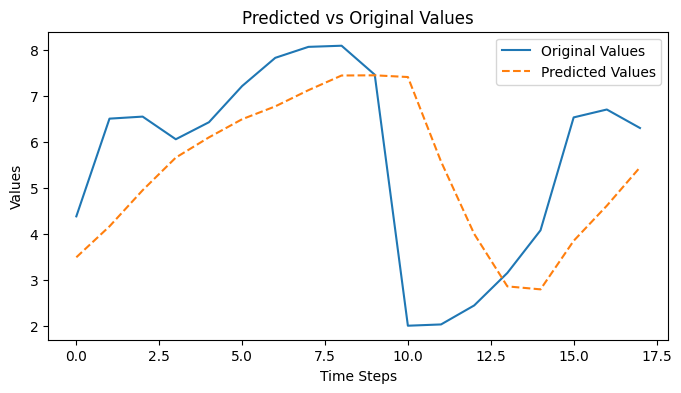

In [135]:
loss = model.evaluate(test_generator)
print(f"Test Loss: {loss}")

predictions = model.predict(test_generator)

predictions_scaled = np.zeros((len(predictions), scaled_test.shape[1]))
predictions_scaled[:, 1] = predictions.squeeze()

test_data = scaled_test[look_back:]
predictions_scaled[:, [0, 2, 3]] = test_data[:, [0, 2, 3]]

predictions_inverse = scaler.inverse_transform(predictions_scaled)
original_test_data_inverse = scaler.inverse_transform(test_data)

original_mean_waterlevel = original_test_data_inverse[:, 1]
predicted_mean_waterlevel = predictions_inverse[:, 1]


# Plot predicted vs original values
plt.figure(figsize=(8, 4))
plt.plot(original_mean_waterlevel, label='Original Values')
plt.plot(predicted_mean_waterlevel, label='Predicted Values', linestyle='dashed')
plt.title('Predicted vs Original Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()